In [1]:
from typing_extensions import TypedDict

class State(TypedDict):
    name: str
    age: int

In [3]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel

class OverallState(BaseModel):
    a: str

In [4]:
def node(state: OverallState):

    return {"a": "Hi I am Suryansh"}

In [5]:
# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(node)
builder.add_edge(START, "node")
builder.add_edge("node", END)
graph = builder.compile()


In [8]:
try:
    graph.invoke({"a": "Hello"})
except Exception as e:
    print(e)

In [9]:
from pydantic import ValidationError

try:
    graph.invoke({"a": 123})
except ValidationError as e:
    print(f"Invalid input | {e}")
except Exception as e:
    print(e)

Invalid input | 1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=123, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Multiple nodes run time validation

In [10]:
from langgraph.graph import StateGraph, START, END
from typing_extensions import TypedDict
from pydantic import BaseModel

class OverallState(BaseModel):
    a: str

def bad_node(state: OverallState):
    return {
        "a": 123
    }

def good_node(state: OverallState):
    return {
        "a": "good bye!"
    }

# Build the state graph
builder = StateGraph(OverallState)
builder.add_node(bad_node)
builder.add_node(good_node)
builder.add_edge(START, "bad_node")
builder.add_edge("bad_node", "good_node")
builder.add_edge("good_node", END)
graph = builder.compile()

In [13]:
try:
    # graph.invoke({"a": "Surya"})

    graph.invoke({"a": 122})
except Exception as e:
    print(e)

1 validation error for OverallState
a
  Input should be a valid string [type=string_type, input_value=122, input_type=int]
    For further information visit https://errors.pydantic.dev/2.10/v/string_type


### Prompt Chaining

In [15]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# Graph State

class State(TypedDict):
    topic: str
    joke: str
    improved_joke: str
    final_joke: str

In [17]:
import os
from dotenv import load_dotenv
load_dotenv()

from langchain_groq import ChatGroq
from langchain_openai import ChatOpenAI

# os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

llm = ChatGroq(model="qwen-2.5-32b")
# llm = ChatOpenAI(model="gpt-4o")
result = llm.invoke("Hello")

print(result)

content='Hello! How can I assist you today?' additional_kwargs={} response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 30, 'total_tokens': 40, 'completion_time': 0.05, 'prompt_time': 0.003738122, 'queue_time': 0.049346087, 'total_time': 0.053738122}, 'model_name': 'qwen-2.5-32b', 'system_fingerprint': 'fp_35f92f8282', 'finish_reason': 'stop', 'logprobs': None} id='run-dea05509-12a7-40be-bfe4-43e7e8115643-0' usage_metadata={'input_tokens': 30, 'output_tokens': 10, 'total_tokens': 40}


In [18]:
# Nodes

def generate_joke(state: State):
    """first LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke on topic {state['topic']}")
    return {
        "joke": msg.content
    }

def check_punchline(state: State):
    """Gate to check if the joke has a punchline"""

    # Simple check - does the joke contains "?" or "!"
    if "?" in state["joke"] or "!" in state["joke"]:
        return "Fail"
    return "Pass"

def improve_joke(state: State):
    """second LLM call to improve the joke"""

    msg = llm.invoke(f"Make this jpoke funnier by adding word play: {state['joke']}")
    return {
        "improved_joke": msg.content
    }

def polish_joke(state: State):
    """third LLM call to make the joke more polished"""

    msg = llm.invoke(f"Add a surprising twist to this joke: {state['improved_joke']}")
    return {
        "final_joke": msg.content
    }

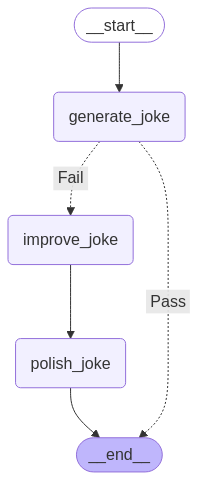

In [21]:
# Build Workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_joke", generate_joke)
workflow.add_node("improve_joke", improve_joke)
workflow.add_node("polish_joke", polish_joke)

# Add edges to connect nodes
workflow.add_edge(START, "generate_joke")
workflow.add_conditional_edges("generate_joke", check_punchline, {"Fail": "improve_joke", "Pass": END})
workflow.add_edge("improve_joke", "polish_joke")
workflow.add_edge("polish_joke", END)

# Compile the graph
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
# Invoke

state = graph.invoke({"topic": "cats"})

In [23]:
state

{'topic': 'cats',
 'joke': "Why don't cats play poker in the wild? Because there are too many cheats (cheetahs)!",
 'improved_joke': 'Why don\'t cats play poker in the wild? Because every time they deal, they end up with a deck full of cheats (cheetahs)! Plus, who can focus on their cards when there\'s a constant purr-ade of "I\'m the king of the savanna" going on?',
 'final_joke': 'Why don\'t cats play poker in the wild? Because every time they deal, they end up with a deck full of cheats (cheetahs)! Plus, who can focus on their cards when there\'s a constant purr-ade of "I\'m the king of the savanna" going on? And to top it all off, one day a clever fox walks by, overhears their game, and decides to join. Turns out, not only can foxes count cards, but they can also predict the next card based on the subtle movements of the cheetahs’ tails!'}

### Parallelization
with parallelization, LLMs works simultaneously on a task

LLMs can sometimes work simultaneously on a task and have their outputs aggregated programitically. This workflow, parallelization, manifests in two key variations: Sectioning : Breaking a task into independent subtasks run in parallel.
Voting: Running the same task multiple times to get diverse outputs.

When to use this workflow ? Parallelization is effective when the divided subtasks can be parallelized for speed, or when multiple perspectives or attempts are needed for highe confidence result.

In [27]:
# graph State

class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

# Nodes

def generate_joke(state: State):
    """LLM call to generate initial joke"""

    msg = llm.invoke(f"Write a short joke on topic {state['topic']}")
    return {
        "joke": msg.content
    }


def generate_story(state: State):
    """LLM call to generate initial story"""

    msg = llm.invoke(f"Write a short story about {state['topic']}")
    return {
        "story": msg.content
    }


def generate_poem(state: State):
    """LLM call to generate initial poem"""

    msg = llm.invoke(f"Write a short poem about {state['topic']}")
    return {
        "poem": msg.content
    }


def combine_output(state: State):
    return {
        "combined_output": f"JOKE: \n\n{state['joke']}\n\n STORY: \n\n{state['story']}\n\n POEM: \n\n{state['poem']}\n\n"
    }

# Build Workflow

parallel_builder = StateGraph(State)

parallel_builder.add_node("generate_joke", generate_joke)
parallel_builder.add_node("generate_story", generate_story)
parallel_builder.add_node("generate_poem", generate_poem)
parallel_builder.add_node("combine_output", combine_output)

# Add edges to connect nodes
parallel_builder.add_edge(START, "generate_joke")
parallel_builder.add_edge(START, "generate_story")
parallel_builder.add_edge(START, "generate_poem")
parallel_builder.add_edge("generate_joke", "combine_output")
parallel_builder.add_edge("generate_story", "combine_output")
parallel_builder.add_edge("generate_poem", "combine_output")
parallel_builder.add_edge("combine_output", END)

# Compile the graph
graph = parallel_builder.compile()

# display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
# Invoke

state = graph.invoke({"topic": "capitalism"})
print(state["combined_output"])

JOKE: 

Why did the capitalist go broke?

Because he thought every problem had a market solution, but in the end, he just couldn't sell enough of his daydreams!

 STORY: 

In the bustling city of Apex, where the skyline was a testament to human ambition, every building vied for supremacy, each taller and more luxurious than the last. At the heart of this city, where dreams of wealth and success were as common as the morning sun, stood two companies: LuminaTech, a sprawling tech enterprise, and GreenFields, a modest organic farm.

LuminaTech, with its sleek skyscraper headquarters, was the epitome of modern capitalism. It produced gadgets that made daily life more efficient and connected, but at the cost of privacy and the environment. Its CEO, a charismatic figure named Marcus, was a paragon of the capitalist ethos. He believed in growth, profits, and the relentless drive to innovate, even if it meant leaving behind the old ways of doing things.

On the other hand, GreenFields, tucked 

### Routing

task classification

In [29]:
from typing_extensions import Literal
from pydantic import BaseModel, Field
from langchain_core.messages import HumanMessage, SystemMessage

# Schema for structured output to use as routing logic
class Route(BaseModel):
    step: Literal["joke", "story", "poem"] = Field(
        None, description="The next step in the routing process"
    )

# Augment the LLM with the schema for structured output
router = llm.with_structured_output(Route)

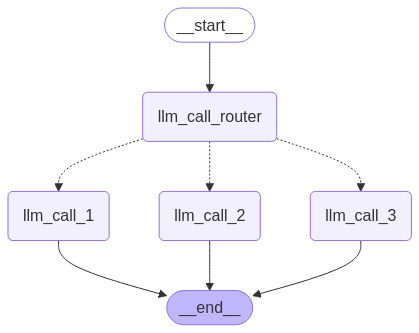

In [30]:
# State

class State(TypedDict):
    input: str
    decision: str
    output: str


# Nodes
def llm_call_1(state: State):
    """Write a story"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_2(state: State):
    """Write a poem"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_3(state: State):
    """Write a joke"""
    result = llm.invoke(state["input"])
    return {"output": result.content}

def llm_call_router(state: State):
    """Route the input to appropriate node"""
    # Run the augmented LLM with structured output to serve as routing logic
    decision = router.invoke([
        SystemMessage(content="Route the input to appropriate node[story, poem, joke] based on users request. "),
        HumanMessage(content=state["input"])
    ])

    return {
        "decision": decision.step,
    }

# conditional edge function to route to the appropriate node
def route_decision(state: State):
    # Return the node name you want to visit next
    if state["decision"] == "story":
        return "llm_call_1"
    elif state["decision"] == "poem":
        return "llm_call_2"
    elif state["decision"] == "joke":
        return "llm_call_3"
    
# Build Workflow
router_builder = StateGraph(State)

# Add nodes
router_builder.add_node("llm_call_1", llm_call_1)
router_builder.add_node("llm_call_2", llm_call_2)
router_builder.add_node("llm_call_3", llm_call_3)
router_builder.add_node("llm_call_router", llm_call_router)

# Add edges to connect nodes
router_builder.add_edge(START, "llm_call_router")
router_builder.add_conditional_edges("llm_call_router", route_decision, {
    "llm_call_1": "llm_call_1",
    "llm_call_2": "llm_call_2",
    "llm_call_3": "llm_call_3"
}) # Name returned by route_decision : Name of next node to visit
router_builder.add_edge("llm_call_1", END)
router_builder.add_edge("llm_call_2", END)
router_builder.add_edge("llm_call_3", END)

# compile the graph
graph = router_builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [31]:
# Invoke

state = graph.invoke({"input": "Write a story about a cat"})
print(state["output"])

In a cozy little house nestled among the lush green trees of a small suburban neighborhood, there lived a cat named Whiskers. Whiskers was no ordinary cat; he was a sleek, black and white furry marvel with eyes that sparkled like polished emeralds. His owner, an elderly widow named Mrs. Harper, cherished him as much as Whiskers adored her.

Mrs. Harper lived alone since her husband's passing, and the house was quiet. It was Whiskers who brought laughter and warmth to the house. His daily antics, from chasing invisible mice to knocking over potted plants, filled the house with cheer. However, Whiskers was not content to be a house cat forever, and one day, he decided to embark on an adventure.

One sunny morning, as Mrs. Harper opened the front door to fetch the newspaper, Whiskers saw his chance. With a quick dart, he slipped out and set off into the neighborhood. He meandered down the street, the world was a big and exciting place for a cat who spent most of his days indoors. He stopp

### Orchestrator Worker

In Orchestrator Worker workflow, a central LLM dynamically breaks down tasks, delegates them to worker LLMs, and synthesizes their results.

In [41]:
from typing import List

# Schema for structured output to the planning
class Section(BaseModel):
    name: str = Field(None, description="Name for this section of report")
    description: str = Field(None, description="Brief overview of the main topics and concepts to be covered in this section")


class Sections(BaseModel):
    sections: List[Section] = Field(None, description="List of sections to be included in the report")

# Augument the LLM with schema for structured output
planner = llm.with_structured_output(Sections)

#### Creating workers in langgraph

Because orchestrator-worker workflows are common, LangGraph has the Send API to support this . It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all workers outputs are written to a shred state key that is accessible to orchatrater graph

In [42]:
from langgraph.constants import Send
from typing import Annotated
import operator

# Graph State
class State(TypedDict):
    topic: str # Report topic
    sections: list[Section] # List of sections
    completed_sections: Annotated[list, operator.add] # All the workers write to this key in parallel
    final_report: str # Final report

# Worker state
class WorkerState(TypedDict):
    section: Section
    completed_sections: Annotated[list, operator.add]

# Nodes
def orchastrater(state: State):
    """Orchastrator that generates a plan for the report"""

    # Generate queries
    report_sections = planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report"),
            HumanMessage(content=f"Here is the report topic : {state["topic"]}")
        ]
    )

    return {"sections": report_sections.sections}

def llm_call(state: WorkerState):
    """Worker that writes a section of the report"""

    # generate section
    section = llm.invoke(
        [
            SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting"),
            HumanMessage(content=f"Here is the section name : {state['section'].name} and description : {state['section'].description}")
        ]
    )

    return {"completed_sections": [section.content]}


def synthesizer(state: State):
    """Synthesize full report from sections"""
    # List of completed sections
    completed_sections = state["completed_sections"]

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)

    # final report
    return {"final_report": completed_report_sections}

# Conditional edge function to create llm_call workers that each write a section of the report
def assign_workers(state: State):
    """Assign a worker to each section in the plan"""
    ## Kick off section writing in parellel via Send() API
    return [Send("llm_call", {"section": s}) for s in state["sections"]]

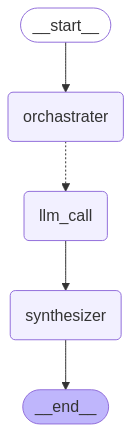

In [43]:
# Build workflow
orchastrator_workflow_builder = StateGraph(State)

# Add the nodes
orchastrator_workflow_builder.add_node("orchastrater", orchastrater)
orchastrator_workflow_builder.add_node("llm_call", llm_call)
orchastrator_workflow_builder.add_node("synthesizer", synthesizer)

# Add edges to connect nodes
orchastrator_workflow_builder.add_edge(START, "orchastrater")
orchastrator_workflow_builder.add_conditional_edges("orchastrater", assign_workers, ["llm_call"])
orchastrator_workflow_builder.add_edge("llm_call", "synthesizer")
orchastrator_workflow_builder.add_edge("synthesizer", END)

# compile the workflow
orchastrator_worker = orchastrator_workflow_builder.compile()

# show the graph
display(Image(orchastrator_worker.get_graph().draw_mermaid_png()))

In [45]:
# Invoke

state = orchastrator_worker.invoke({"topic": "Create a report on Microservice Architecture"})

# print(state)
from IPython.display import Markdown
Markdown(state["final_report"])

## Introduction to Microservice Architecture

Microservice architecture is a design approach that structures an application as a collection of loosely coupled services, which implement business capabilities. Each service is a small, independent process that communicates with other services through well-defined APIs. This architectural style emphasizes the idea of dividing complex software systems into smaller, manageable, and maintainable pieces, each of which can be developed, deployed, and scaled independently.

The principles behind microservices include:

- **Decentralization and autonomy**: Each microservice operates independently and can be managed by a small, autonomous team. This allows for faster development cycles and more flexible scaling.
- **Service boundaries**: Services are organized around business capabilities and are loosely coupled, which means they can be deployed and updated without affecting other services.
- **Technology diversity**: Teams can choose the most appropriate technology stack for each service based on its specific requirements.
- **Resilience and fault isolation**: Since services are independent, a failure in one service does not necessarily impact the functionality of the entire application.
- **DevOps culture**: The design encourages a DevOps culture, where development and operations teams work closely together to ensure a smooth delivery and deployment process.

Microservices are particularly beneficial in large-scale applications that require high scalability, flexibility, and resilience. They enable organizations to innovate more rapidly and respond effectively to changing business needs.

---

### Benefits of Microservice Architecture

Microservices architecture offers several advantages over traditional monolithic architectures. Firstly, **enhanced scalability** is a key benefit; microservices allow teams to scale specific parts of an application independently, based on demand, rather than scaling the entire application. This targeted scaling improves resource utilization and cost-effectiveness.

Another significant advantage is **improved fault isolation**. In a monolithic application, a single bug can bring down the entire system. In contrast, with microservices, a failure in one service can be isolated, preventing it from impacting the entire application. This feature not only enhances the resilience of the application but also makes troubleshooting more straightforward.

The **flexibility in technology choice** is another major benefit. Each microservice can be built using the most suitable technology stack, which is ideal for complex applications that may require different technologies for different services. This flexibility allows teams to adopt new technologies more quickly and tailor their solutions to specific needs.

Furthermore, **enhanced productivity** through parallel and independent development cycles is a significant advantage. Teams can work on different services simultaneously, accelerating development and deployment cycles. Continuous integration and continuous delivery (CI/CD) practices can be easily implemented, leading to faster time-to-market for new features and improvements.

Lastly, **easier maintenance and updates** are facilitated by microservices. Because each service is independent, updates and bug fixes can be performed on a per-service basis, without the need to redeploy the entire application. This results in reduced maintenance costs and a more manageable codebase.

Overall, microservices architecture provides a modular approach that not only improves application performance and reliability but also enhances the agility and efficiency of the development process.

---

### Challenges and Limitations

Transitioning to a microservices architecture presents a myriad of challenges and limitations. These primarily revolve around complexity in system design, operational overhead, and the need for robust communication protocols.

#### Complexity in System Design

One of the most significant challenges is the increased complexity of system design. With microservices, the system is decomposed into a large number of small, independently deployable services, each with its own database. This fragmentation can lead to a more complex architecture that is harder to understand and maintain. Developers must carefully design these services to ensure they remain small, focused, and loosely coupled.

#### Operational Overhead

Microservices introduce a higher operational overhead compared to monolithic applications. This is because each service needs to be independently deployed, scaled, and monitored. The infrastructure required to support this can be extensive, including robust CI/CD pipelines, automated testing, and dynamic scaling mechanisms. Additionally, managing the deployment lifecycle of numerous microservices is more resource-intensive and requires specialized skills.

#### Communication and Data Management

Effective communication between services is another critical challenge. Services must interact seamlessly, which necessitates the use of reliable communication protocols such as REST or gRPC. However, this interaction introduces network latency, points of failure, and the need for fault tolerance mechanisms like retries and circuit breakers.

Data management also becomes more complex. Each microservice typically has its own database, leading to a polyglot persistence environment. While this allows services to choose the best database for their specific needs, it also complicates data consistency and integrity across the system. Ensuring that data updates are consistent and coherent across multiple services can be a significant challenge.

#### Security

Security considerations are magnified in a microservices environment. With multiple services and databases, the potential attack surface increases. Traditional security measures need to be rethought, focusing on securing each microservice individually, as well as the communication channels between them. This often involves implementing identity and access management, encryption, and secure communication protocols.

#### Migration and Integration

For organizations migrating from monolithic applications to a microservices architecture, the process can be arduous and risky. Breaking down monolithic systems into smaller, independent services requires significant refactoring and can lead to unforeseen issues. Integrating microservices with existing legacy systems can also present technical and logistical challenges.

In summary, while microservices offer compelling benefits such as scalability and resilience, they are accompanied by significant challenges and limitations. Organizations must carefully consider these factors and implement appropriate strategies to manage the increased complexity and operational demands that come with adopting a microservices architecture.

---

## Microservice Design Patterns

Design patterns in microservices architecture are essential for addressing common challenges and promoting best practices in the development and deployment of microservices. Several design patterns have emerged as particularly useful in this context:

### API Gateway
An API Gateway acts as a single entry point for all clients to access microservices. It handles requests, routes them to the appropriate microservice, and aggregates the responses. This pattern simplifies the client by hiding the system’s complexity and providing a unified API.

### Service Discovery
In a microservices architecture, services often need to locate and communicate with other services. Service Discovery patterns help services find and connect to each other dynamically, facilitating scalability and resilience.

### Circuit Breaker
The Circuit Breaker pattern is used to detect when a service is failing and prevent further calls to the failing service. This helps to avoid cascading failures and allows the system to degrade gracefully under failure conditions.

### Sidecar
In the Sidecar pattern, a companion service is deployed alongside the main application to handle specific tasks like monitoring, logging, and networking. This keeps the main application focused on its core functionality while offloading auxiliary tasks.

### Backend for Frontend (BFF)
A BFF is a pattern where a specialized API is created for each frontend client. This allows the API to be optimized for the specific needs of the client, such as different devices or user roles, improving performance and user experience.

### Command Query Responsibility Segregation (CQRS)
CQRS is a pattern that separates read and write operations into distinct models. This separation allows for more efficient handling of read-heavy and write-heavy operations, enhancing the scalability and performance of the system.

### Event Sourcing
Event Sourcing is a pattern in which changes to application state are stored as a sequence of events. This approach enables better auditing, history tracking, and can simplify implementing features such as undo/redo operations.

### Saga
Sagas are used to manage long-running business transactions that span multiple services. They ensure that all services involved in a transaction can complete their operations successfully or roll back changes if any step fails, thus maintaining consistency across the system.

### Bulkhead
The Bulkhead pattern is used to isolate failures by splitting resources and dependencies into separate pools. This prevents a failure in one part of the system from affecting other parts, thereby improving fault tolerance.

These design patterns provide a robust foundation for building and managing microservices, offering solutions to common architectural and operational challenges. By leveraging these patterns, developers can create more resilient, scalable, and maintainable microservices architectures.

---

## Tooling and Technologies

The implementation, monitoring, and management of microservices rely on a variety of tools and technologies to ensure efficiency, scalability, and reliability. Key components include containerization platforms such as Docker for packaging applications and dependencies into lightweight, portable containers. Kubernetes is a widely adopted orchestration system used to automate the deployment, scaling, and management of containerized applications.

For service discovery and communication, tools such as Apache ZooKeeper and Consul are often used to maintain a dynamic inventory of services and facilitate communication between microservices. API gateways like Kong and Netflix Zuul provide a single entry point for clients to access the microservices, handling tasks such as request routing and load balancing.

Monitoring and logging are critical for maintaining the health and performance of microservices. Tools like Prometheus and Grafana offer robust monitoring solutions that allow for real-time tracking of application performance and resource usage. ELK Stack (Elasticsearch, Logstash, Kibana) and Fluentd are popular choices for log collection, processing, and visualization.

Additionally, CI/CD pipelines powered by Jenkins, GitLab CI, and CircleCI enable continuous integration and delivery, streamlining the development and deployment processes. These tools work together to create a comprehensive microservices architecture that is both powerful and manageable.

---

### Case Study: Successful Implementation

One exemplary case of successful microservices implementation is the transformation of the online retail giant, Amazon. Initially, Amazon operated as a monolithic application, but as the company scaled, the need for increased agility and scalability became apparent. Amazon began its transition to microservices, breaking down its monolithic architecture into smaller, independent services.

Each microservice in Amazon’s architecture is responsible for a specific business function, such as product recommendations, order processing, or customer reviews. This decomposition allows teams to focus on specific parts of the system, enabling rapid development and deployment without the risk of destabilizing the entire application.

Amazon’s implementation also emphasizes the importance of a robust service-oriented architecture (SOA) with well-defined APIs and communication protocols. This ensures that microservices can interact seamlessly, even as they evolve independently. Additionally, Amazon has implemented rigorous monitoring and logging practices to maintain operational reliability and to quickly diagnose and resolve issues.

The benefits of this approach are evident in Amazon's ability to introduce new features and innovations at a rapid pace, while also handling the massive traffic and transaction volumes typical of a global e-commerce leader. The microservices architecture has been a key enabler for Amazon's continued success and competitive advantage in the market.

---

### Best Practices

- **Modular Design**: Design microservices to handle specific business capabilities. Each microservice should have a clear, single responsibility and a well-defined scope.

- **API Gateway**: Use an API gateway to provide a unified interface for clients and manage the interaction with the microservices.

- **Service Discovery**: Implement a service discovery mechanism to enable services to locate and communicate with each other without hardcoding IP addresses or ports.

- **Circuit Breaker**: Implement circuit breaker patterns to prevent a failure in one microservice from cascading to others, improving system resilience.

- **Data Management**: Each microservice should own its database and data management to ensure loose coupling and high cohesion. Avoid sharing databases between services.

- **Configuration Management**: Use centralized configuration management to handle different environments (development, staging, production) and to externalize configuration from code.

- **Monitoring and Logging**: Implement comprehensive monitoring and logging to track the behavior and performance of microservices. Logs should be aggregated and processed for analysis.

- **Continuous Integration/Continuous Deployment (CI/CD)**: Establish CI/CD pipelines to automate testing and deployment, ensuring that new changes are thoroughly tested and integrated smoothly into the environment.

- **Security**: Apply security at the infrastructure, platform, and application level. Use authentication, authorization, and encryption to protect data and services.

- **Documentation**: Maintain clear and up-to-date documentation for each microservice, including APIs, operational requirements, and deployment instructions.

### Evaluator optimizer

In Evaluator optimizer, one LLM call generates a response while another provides evaluation and feedback in a loop.

In [ ]:
# Graph State

class State(TypedDict):
    joke: str
    topic: str
    feedback: str
    funny_or_not: str

# schema for structured output to use in evaluation
class FeedBack(BaseModel):
    grade: Literal["funny", "not funny"] = Field(
        None, description="Decide if the joke is funny or not"
    )
    feedback: str = Field(
        None, description="If joke is not funny, provide feedback on how to improve it"
    )


# Augument the LLM with schema for structured output
evaluator = llm.with_structured_output(FeedBack)

# Nodes
def llm_call_generator(state: State):
    """LLM generates a joke"""
    if  state.get("feedback"):
        msg = llm.invoke(
            f"Write a joke about {state['topic']} but take account the feedback: {state['feedback']}"
        )
    else:
        msg = llm.invoke(f"Write a joke about {state['topic']}")

    return {"joke": msg.content}

def llm_call_evaluator(state: State):
    """LLM evaluates the joke"""
    grade = evaluator.invoke(
        f"grade the joke {state['joke']}"
    )
    return {"funny_or_not": grade.grade, "feedback": grade.feedback}

# Conditional edge function to route back to a joke generator or end based upon feedback from the evaluator
def route_joke(state: State):
    """Route back to joke generator or end based upon feedback from the evaluator"""

    if state["funny_or_not"] == "funny":
        return "Accepted"
    elif state["funny_or_not"] == "not funny":
        return "Rejected + feedback"